In [11]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64

import json
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [12]:
warnings.filterwarnings('ignore')

In [13]:
def BL2dhist_var_condition(df, df_var):
    
    """
    get conditional average of the variable binned by BL,cape and BL,subsat
    """

    # bins for BL_CAPE and BL_SUBSAT
    bins_cape = np.linspace(-10,10,101)
    bins_subsat = np.linspace(-5,15,101)
    dbl_cape = (bins_cape[1]-bins_cape[0])/2
    dbl_subsat= (bins_subsat[1]-bins_subsat[0])/2

    samples = np.zeros((6, len(bins_cape)-1, len(bins_subsat)-1)) # (mcs_phase, surface_type, BL-cape, BL-subsat) 
    var_sum = np.zeros((6, len(bins_cape)-1, len(bins_subsat)-1))

    for track_sel in df.tracks.values:
        df_sub = df.sel(tracks=track_sel)
        df_var_sub = df_var.sel(tracks=track_sel)
    
        for p,phase in enumerate(['CCS','Init','Grow','Mature','Decay','End']):

            cmask = df_sub.cloudtracknumber_nomergesplit.sel(time=p)
            BL_CAPE = df_sub.Buoy_CAPE.sel(time=p)*(340*3/9.8)
            cape_1d = BL_CAPE.where(cmask > 0).values.ravel()
            BL_SUBSAT = df_sub.Buoy_SUBSAT.sel(time=p)*(340*3/9.8)
            subsat_1d = BL_SUBSAT.where(cmask > 0).values.ravel()
            var = df_var_sub.sel(time=p)
            var_1d = var.where(cmask > 0).values.ravel()

            # remove np.nan
            var_1d = var_1d[~np.isnan(cape_1d)]
            subsat_1d = subsat_1d[~np.isnan(cape_1d)]
            cape_1d = cape_1d[~np.isnan(cape_1d)]
    
            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]
                    idx_com = np.intersect1d(idx,idy)
                    samples[p,i,j] += len(idx_com)
                    var_sum[p,i,j] += np.sum(var_1d[idx_com])

    # write into xarray dataset
    ds = xr.Dataset(data_vars=dict(samples=(['mcs_phase','bins_cape','bins_subsat'],samples),
                                   var_sum=(['mcs_phase','bins_cape','bins_subsat'],var_sum)),
                    coords=dict(mcs_phase=(['mcs_phase'],['CCS','Init','Grow','Mature','Decay','End']),
                                bins_cape=(['bins_cape'],bins_cape[:-1]),
                                bins_subsat=(['bins_subsat'],bins_subsat[:-1])))    
    
    return ds

In [20]:
# load written outputs
data_dir = Path('/scratch/wmtsai/MCSFLEXTRKR_tropics_buoyancy')
year = 2017
buoy = xr.open_dataset(data_dir / 'MCS_FLEXTRKR_tropics_buoyancy.30NS.{}.nc'.format(year))

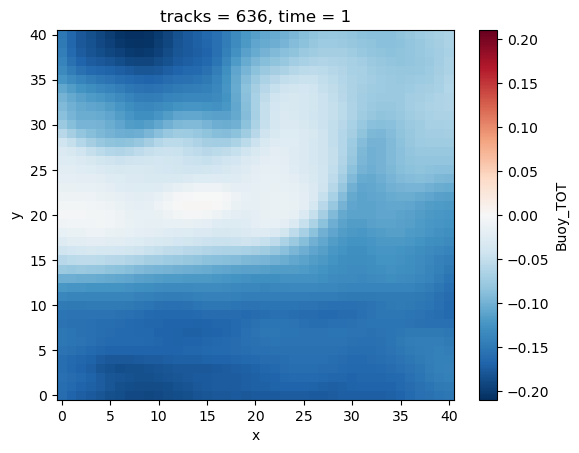

In [21]:
buoy.isel(tracks=100,time=1).Buoy_TOT.plot()

In [17]:
test = buoy.Buoy_TOT.isel(tracks=slice(1,100)).values

(array([4.60000e+01, 1.07000e+02, 1.11900e+03, 2.02000e+03, 1.57400e+03,
        1.62600e+03, 3.54200e+03, 4.40700e+03, 5.42500e+03, 9.35700e+03,
        1.56080e+04, 2.43240e+04, 4.01270e+04, 6.17190e+04, 9.85470e+04,
        2.12909e+05, 3.40995e+05, 1.67848e+05, 6.95500e+03, 1.60000e+01]),
 array([-0.35617805, -0.33626101, -0.31634397, -0.29642693, -0.27650989,
        -0.25659285, -0.23667581, -0.21675877, -0.19684173, -0.17692469,
        -0.15700765, -0.13709062, -0.11717358, -0.09725654, -0.0773395 ,
        -0.05742246, -0.03750542, -0.01758838,  0.00232866,  0.0222457 ,
         0.04216274]),
 <BarContainer object of 20 artists>)

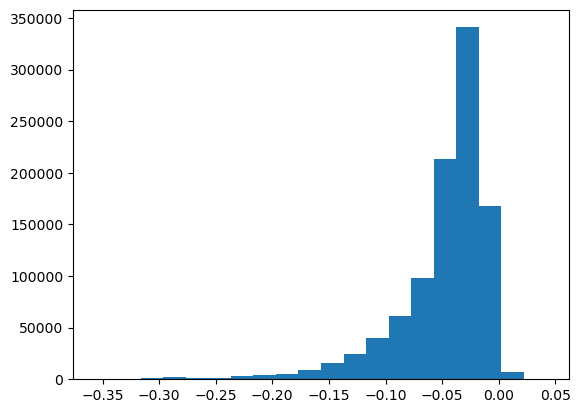

In [18]:
plt.hist(test.ravel(), bins=20)

In [ ]:
data_allmerge = xr.merge([buoy, omega, mcs_mask], compat='override')

In [ ]:
%%time
ds_BLhist2d_500hpa = BL2dhist_var_condition(data_allmerge, data_allmerge.sel(level=500).w)
ds_BLhist2d_850hpa = BL2dhist_var_condition(data_allmerge, data_allmerge.sel(level=850).w)

In [ ]:
cond_mean_500hpa = ds_BLhist2d_500hpa.var_sum/ds_BLhist2d_500hpa.samples
#cond_mean_500hpa = cond_mean_500hpa.where(ds_BLhist2d_500hpa.samples > 100)
cond_mean_850hpa = ds_BLhist2d_850hpa.var_sum/ds_BLhist2d_850hpa.samples

In [ ]:
cond_mean_500hpa.sel(mcs_phase='Mature').plot(vmin=-4,vmax=1,cmap='jet')
cond_mean_500hpa.sel(mcs_phase='Mature').plot.contour(levels=[-2,-1.5,-1,0,1], colors=['k'])
# set x-y domain 

# add buoyancy reference 
plt.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1.5)
plt.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
plt.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='k', ls='-',lw=0.5)
plt.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='k', ls='-',lw=0.5)
plt.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)

plt.ylim([-8,6])
plt.xlim([-2,14])  

In [ ]:
cond_mean_850hpa.sel(mcs_phase='Mature').plot(vmin=-4, vmax=1, cmap='RdBu')
cond_mean_850hpa.sel(mcs_phase='Mature').plot.contour(levels=[-2,-1.5,-1,0], colors=['k'])
# set x-y domain 
plt.ylim([-8,6])
plt.xlim([-2,14])  

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))

for i in range(10):
    
    omega = data_allmerge.isel(tracks=i,time=2).sel(level=850).w
    cmask = mcs_mask.isel(tracks=i,time=2).cloudtracknumber_nomergesplit
    Buoy_TOT = data_allmerge.isel(tracks=i,time=2).Buoy_TOT*(340*3/9.8)
    omega_mcs = omega.where(cmask > 0)
    buoy_mcs = Buoy_TOT.where(cmask > 0)
    
    ax.scatter(buoy_mcs, -omega_mcs, s=10)
ax.set_ylabel('Omega at 850hPa [Pa/s]')
ax.set_xlabel('Buoyancy, B$_{L}$ [K]')
ax.set_ylim([-1,3])
ax.set_xlim([-7.5,2])